In [ ]:
!pip install Pillow
!pip install rasterio
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 43.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import tensorflow as tf
import cv2
import os,re
import rasterio
from random import randint
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
from keras.layers import Input
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [ ]:
tifpath = "/content/drive/My Drive/dataset/images/"
bmppath = "/content/drive/My Drive/dataset/mask/"
bmpfol = []
tiffol=[]
for image in os.listdir(tifpath):
    tiffol.append(image)
for _ in os.listdir(bmppath):
  bmpfol.append(_)
print(bmppath + bmpfol[350])
print('\n',len(bmpfol))
print('\n',len(tiffol))

/content/drive/My Drive/dataset/mask/time-20170691915027-loc--96.7_36.3_-96.0_36.8.bmp

 352

 352


In [ ]:
srb = rasterio.open(bmppath + bmpfol[350])
#Rasterio Color Interpretation of bmp Image
srb.colorinterp[0]

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<ColorInterp.palette: 2>

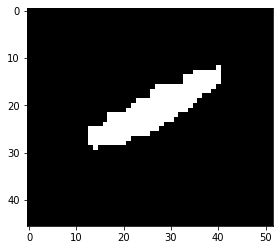

In [ ]:
plt.imshow(srb.read(1), cmap='gray')
plt.show()

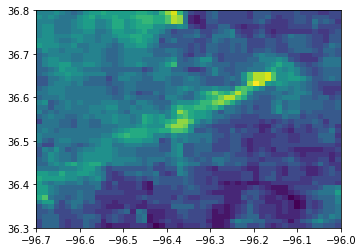

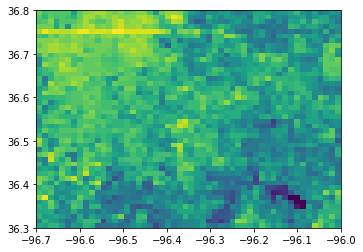

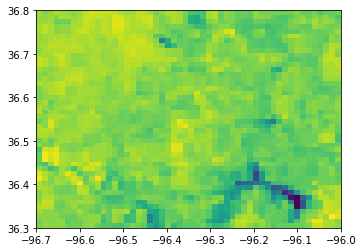

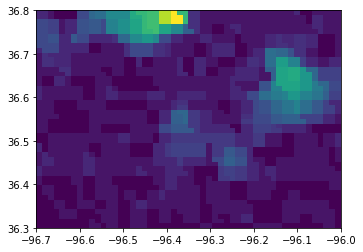

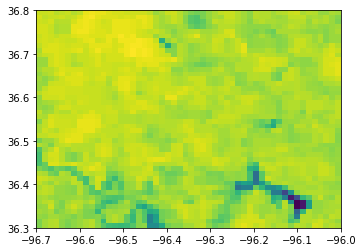

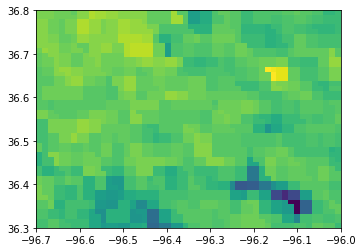

In [ ]:
srt = rasterio.open(tifpath + tiffol[350])
for _ in range(1,7):
  try:
    show(srt.read(_),transform=srt.transform)
  except IndexError:
    break

In [ ]:
path = tifpath + '/' + tiffol[350]
with rasterio.open(path) as src:
    tifa = src.read()
    tifa = tifa.reshape(46,52,6)
    meta = src.meta
    #Tagged Raster Image into N-Dimensional Array
    print(tifa)

[[[ 85  85  85  86  85  84]
  [ 83  84  86  87  87  88]
  [ 87  87  87  87  87  88]
  ...
  [ 82  81  80  82  83  81]
  [ 80  81  82  84  83  83]
  [ 82  81  81  80  82  82]]

 [[ 86  86  86  85  84  84]
  [ 85  86  85  85  84  85]
  [ 85  84  86  86  87  88]
  ...
  [ 83  83  83  84  84  85]
  [ 86  88  86  86  83  82]
  [ 81  82  83  84  84  84]]

 [[ 83  83  84  85  87  86]
  [ 86  85  84  84  84  83]
  [ 83  83  83  83  83  83]
  ...
  [ 93  90  86  83  83  83]
  [ 84  84  83  84  85  85]
  [ 84  82  82  80  80  81]]

 ...

 [[100  97  99  99 100 100]
  [ 99  99 100  99  99 101]
  [101  98  98 100 102 102]
  ...
  [ 96  96  82  82  94 101]
  [101  99  99 100 100 100]
  [ 99  99 101 101  99  96]]

 [[ 97  94  94  96  96  98]
  [ 96  96 102 102 101 101]
  [ 96  95  95  99  99 102]
  ...
  [ 91  90  96  96  91  91]
  [ 73  73  68  73  73  90]
  [ 90  99  99 100  98  98]]

 [[ 99  99 101  94  94  97]
  [ 97  97  97  96  89  89]
  [ 88  88  94  94  91  86]
  ...
  [100 101 101 101 101 1

In [ ]:
bmpa = np.array(srb.read(1))
#Bitmap Image into N-Dimensional array
bmpa

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

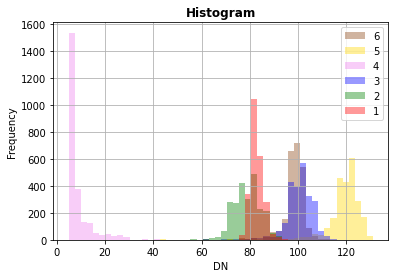

In [ ]:
show_hist(
    tifa.reshape(6,46,52), bins=50, lw=0.0, stacked=False, alpha=0.4,
    histtype='stepfilled', title="Histogram")

In [ ]:
print(tifa.shape)
print(tifa.dtype)
print(meta)

(46, 52, 6)
uint8
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 52, 'height': 46, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.013461538461538516, 0.0, -96.7,
       0.0, -0.010869565217391304, 36.8)}


In [ ]:
print(bmpa.shape)

(46, 52)


In [ ]:
Y = []
for path in bmpfol:
  imgy = cv2.imread(os.path.join(bmppath,path))
  Y.append(imgy)
len(Y)

352

In [ ]:
X = []
for path in tiffol:
  with rasterio.open(os.path.join(tifpath,path)) as srt:
    imgy=srt.read()
  X.append(imgy)
len(X)

352

In [ ]:
for i in range(0,len(X)):
  print(X[i].shape)
  print(Y[i].shape,'\n')

In [ ]:
#just in case scaling function
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (224, 224)) # Resizing the image to 224x224 dimention
    return image

# Ideas
Do we need to scale the images? Do we need to 

In [ ]:
inputs = tf.keras.layers.Input((6, 512, 512))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansion Path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

ValueError: ignored

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=5)